In [1]:
%load_ext autoreload
%autoreload 2

from typing import List, Dict

import sys
import yaml
sys.path.append('.')
sys.path.append('..')

import time
from tqdm import tqdm
from pathlib import Path

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import datasets
import eval
import models.diffusion
from models.diffusion_utils import generate
from models.train_utils import create_input_iter

from ml_collections.config_dict import ConfigDict

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

2024-01-04 10:19:42.410243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 10:19:42.410283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 10:19:42.411621: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 10:19:44.501555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [109]:
path_to_model = Path("/mnt/ceph/users/tnguyen/dark_camels/point-cloud-diffusion-logging/"\
    "cosmology/gallant-bush-49")

with open(path_to_model / "config.yaml", "r") as file:
    config = yaml.safe_load(file)
config = ConfigDict(config)

# read in the data
x, mask, conditioning, norm_dict = datasets.get_nbody_data(
    config.data.dataset_root,
    config.data.dataset_name,
    config.data.n_features,
    config.data.n_particles,
    split='train',
    conditioning_parameters=config.data.conditioning_parameters,
)

# unnormalized x
x = x * norm_dict['std'] + norm_dict['mean']

# load the model
vdm, params = models.diffusion.VariationalDiffusionModel.from_path_to_model(
    path_to_model=path_to_model, norm_dict=norm_dict)

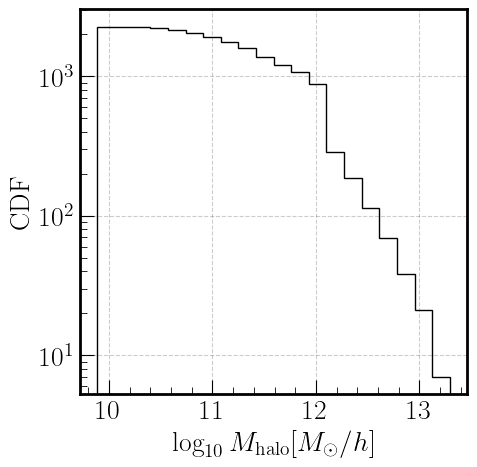

In [106]:
# plot the halo mass function
fig, ax = plt.subplots(figsize=(5, 5))

ax.hist(
    conditioning.ravel(), bins=20, density=False, histtype='step',
    cumulative=-1, color='k')
ax.set_xlabel(r'$\log_{10} M_{\rm halo} [M_\odot / h]$')
ax.set_ylabel(r'$\rm CDF$')
ax.set_yscale('log')

plt.show()

In [119]:
rng = jax.random.PRNGKey(42)
steps = 1000
num_particles = 10
num_repeats = 10

mass_bin_lo = 10.
mass_bin_hi = 11.
select = jnp.where(
    (conditioning >= mass_bin_lo) & (conditioning < mass_bin_hi))[0]
truth_samples = x[select]

cond_batch = jnp.repeat(conditioning[select], num_repeats, axis=0)
mask_batch = jnp.repeat(mask[select], num_repeats, axis=0)

gen_samples = eval.generate_samples(
    vdm=vdm,
    params=params,
    rng=rng,
    n_samples=num_repeats * len(select),
    n_particles=num_particles,
    conditioning=cond_batch,
    mask=mask_batch,
    steps=steps,
    norm_dict=norm_dict,
    boxsize=1,  # doesn't matter
)
gen_samples = np.array(gen_samples)

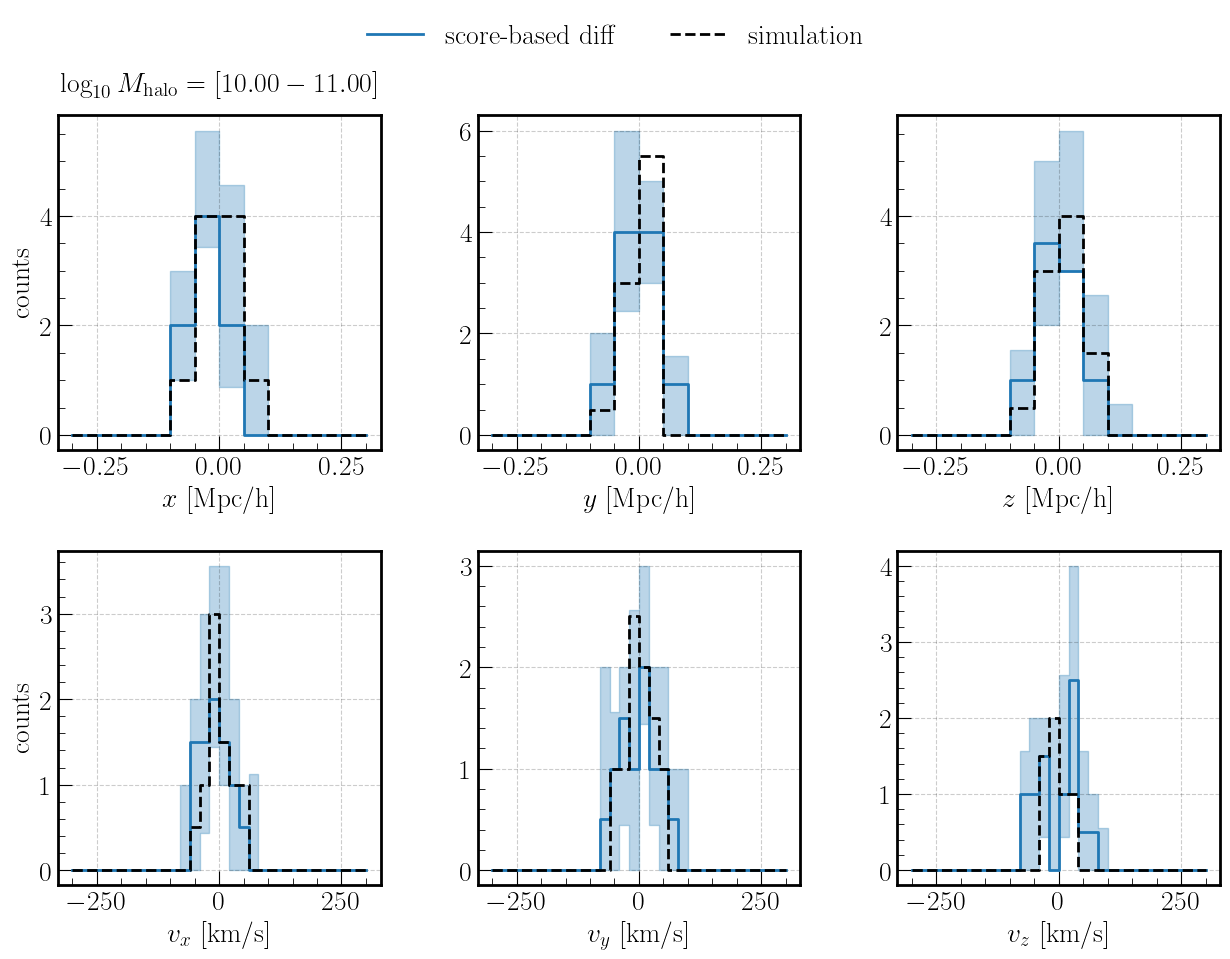

In [120]:
bin_sizes = (
    0.05, 0.05, 0.05, 
    20, 20, 20
)
plot_ranges = (
    (-0.3, 0.3), (-0.3, 0.3), (-0.3, 0.3), 
    (-300, 300), (-300, 300), (-300, 300)
)
q = [50, 16, 84, 2.5, 97.5]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.ravel()):

    bins = np.arange(plot_ranges[i][0], plot_ranges[i][1] + bin_sizes[i], bin_sizes[i])
    num_bins = len(bins) - 1
    bins_plot = np.zeros(2 * num_bins)
    bins_plot[::2] = bins[:-1] 
    bins_plot[1::2] = bins[1:]

    # plot percentiles as shaded region
    counts = [np.histogram(gen_samples[j, :, i], bins=bins)[0] for j in range(num_repeats)]
    counts = np.stack(counts, axis=0)
    counts_q = np.nanpercentile(counts, q=q, axis=0)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    # plot the truth
    counts = [np.histogram(truth_samples[j, :, i], bins=bins)[0] for j in range(num_repeats)]
    counts = np.stack(counts, axis=0)
    counts_q = np.nanpercentile(counts, q=q, axis=0)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, ls='--',
        label='simulation')
    # ax.plot(
    #     bins_plot, counts_q[1].repeat(2), color='k', lw=2, ls=':')
    # ax.plot(
    #     bins_plot, counts_q[2].repeat(2), color='k', lw=2, ls=':')

# annotate the mass bins at the center top of the plot
text = r"$\log_{10} M_{\rm halo} = [%.2f - %.2f$]" % (mass_bin_lo, mass_bin_hi)
axes[0, 0].text(
    0.5, 1.05, text,
    transform=axes[0, 0].transAxes, ha='center', va='bottom')

axes[0, 0].set_xlabel(r'$x$ [Mpc/h]')
axes[0, 1].set_xlabel(r'$y$ [Mpc/h]')
axes[0, 2].set_xlabel(r'$z$ [Mpc/h]')
axes[1, 0].set_xlabel(r'$v_x$ [km/s]')
axes[1, 1].set_xlabel(r'$v_y$ [km/s]')
axes[1, 2].set_xlabel(r'$v_z$ [km/s]')
axes[0, 0].set_ylabel(r'counts')
axes[1, 0].set_ylabel(r'counts')

# create handles
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

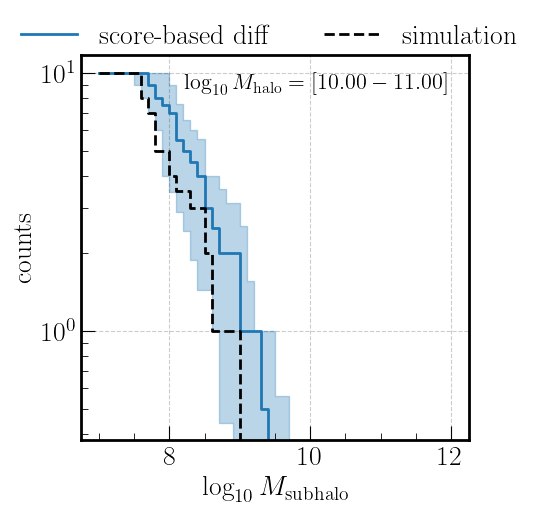

In [121]:
bin_size = 0.1
plot_range = (7, 12)

if gen_samples.shape[-1] == 7:
    # plot the log mass

    fig, ax = plt.subplots(1, figsize=(5, 5))

    bins = np.arange(plot_range[0], plot_range[1] + bin_size, bin_size)
    num_bins = len(bins) - 1
    bins_plot = np.zeros(2 * num_bins)
    bins_plot[::2] = bins[:-1] 
    bins_plot[1::2] = bins[1:]

    # plot percentiles as shaded region
    counts = [np.histogram(gen_samples[j, :, -1], bins=bins)[0] for j in range(num_repeats)]
    counts = np.stack(counts, axis=0)
    counts = counts.sum(1, keepdims=True) - np.cumsum(counts, axis=1)
    counts_q = np.nanpercentile(counts, q=q, axis=0)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    # plot percentiles as shaded region
    counts = [np.histogram(truth_samples[j, :, -1], bins=bins)[0] for j in range(num_repeats)]
    counts = np.stack(counts, axis=0)
    counts = counts.sum(1, keepdims=True) - np.cumsum(counts, axis=1)
    counts_q = np.nanpercentile(counts, q=q, axis=0)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, 
        ls='--', label='simulation')

    # annotate the mass bins at the center top of the plot
    text = r"$\log_{10} M_{\rm halo} = [%.2f - %.2f$]" % (mass_bin_lo, mass_bin_hi)
    ax.text(
        0.95, 0.9, text, fontsize=16,
        transform=ax.transAxes, ha='right', va='bottom')

    ax.set_yscale('log')
    ax.set_xlabel(r'$\log_{10} M_{\rm subhalo}$')
    ax.set_ylabel(r'counts')

    # create handles
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles, labels, loc='upper center', ncol=2, fontsize=20)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

### Density profiles

In [122]:
import jeansgnn_utils as jgnn_ut

In [123]:
r_min = 0.1
r_max = 1
num_bins = 10

gen_log_rho = []
logr_bins = None
for sample in gen_samples:
    rad = np.sqrt((sample[:, :3]**2).sum(axis=-1))
    mass = 10**sample[:, -1]
    rho, _, logr_bins = jgnn_ut.particles.calc_rho(rad, mass, r_min, r_max, num_bins)
    gen_log_rho.append(np.log10(rho))
gen_log_rho = np.array(gen_log_rho)
gen_log_rho_q = np.nanpercentile(gen_log_rho, q=q, axis=0)
logr_ce = 0.5 * (logr_bins[1:] + logr_bins[:-1])

truth_log_rho = []
for sample in truth_samples:
    rad = np.sqrt((sample[:, :3]**2).sum(axis=-1))
    mass = 10**sample[:, -1]
    rho, _, logr_bins = jgnn_ut.particles.calc_rho(
        rad, mass, r_min, r_max, num_bins)
    truth_log_rho.append(np.log10(rho))
truth_log_rho = np.array(truth_log_rho)
truth_log_rho_q = np.nanpercentile(truth_log_rho, q=q, axis=0)
logr_ce = 0.5 * (logr_bins[1:] + logr_bins[:-1])

/mnt/home/tnguyen/my_modules/jeansgnn_utils/particles.py:65: RuntimeWarning: invalid value encountered in divide
  sigma_rho = rho / np.sqrt(count_bins)
/tmp/ipykernel_3248473/2738760295.py:11: RuntimeWarning: divide by zero encountered in log10
  gen_log_rho.append(np.log10(rho))
/mnt/home/tnguyen/miniconda3/envs/galaxy-diffusion-release/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_3248473/2738760295.py:22: RuntimeWarning: divide by zero encountered in log10
  truth_log_rho.append(np.log10(rho))
/mnt/home/tnguyen/miniconda3/envs/galaxy-diffusion-release/lib/python3.10/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


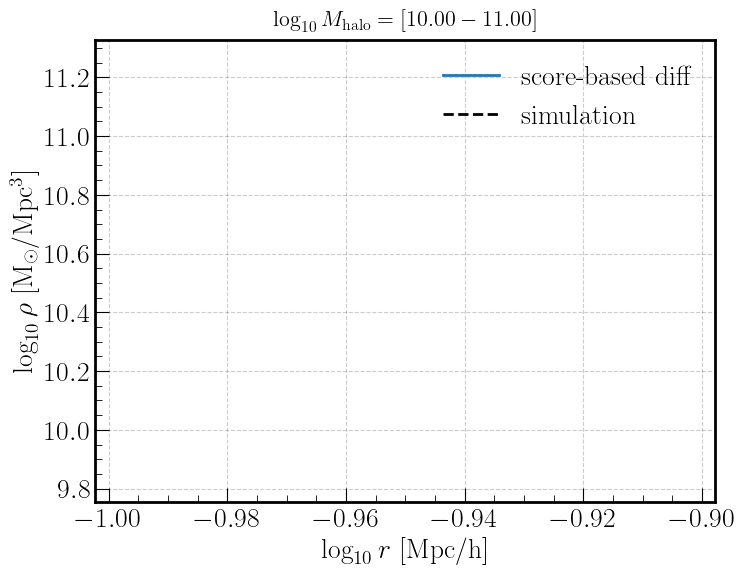

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(
    logr_ce, gen_log_rho_q[0], color='C0', lw=2,
    label='score-based diff')
ax.fill_between(
    logr_ce, gen_log_rho_q[1], gen_log_rho_q[2],
    color='C0', alpha=0.3)
ax.fill_between(
    logr_ce, gen_log_rho_q[3], gen_log_rho_q[4],
    color='C0', alpha=0.3)
ax.plot(
    logr_ce, truth_log_rho_q[0], color='k', ls='--', lw=2,
    label='simulation')
ax.plot(
    logr_ce, truth_log_rho_q[1], color='k', ls=':', lw=2)
ax.plot(
    logr_ce, truth_log_rho_q[2], color='k', ls=':', lw=2)

text = r"$\log_{10} M_{\rm halo} = [%.2f - %.2f$]" % (mass_bin_lo, mass_bin_hi)
ax.set_title(text, fontsize=16)
ax.set_xlabel(r'$\log_{10} r$ [Mpc/h]')
ax.set_ylabel(r'$\log_{10} \rho$ [M$_\odot$/Mpc$^3$]')
ax.legend(loc='upper right', fontsize=20)
plt.show()

### TPCF

In [125]:
def calc_pair_dist(pos1, pos2):
    diff = (pos1[:, None, :] - pos2[None, :, :])
    dist = np.sqrt((diff**2).sum(axis=-1))
    dist = dist[dist > 0]  # only works if there are no particles at the same position
    return dist

def calc_tpcf(pos, num_random_factor=10, box_size=1):
    # randomly generate the catalogs7
    num_random = int(num_random_factor * len(pos))
    pos_random = np.random.uniform(
        low=-box_size, high=box_size, size=(num_random, pos.shape[-1]))
    DR_dist = calc_pair_dist(pos, pos_random)
    RR_dist = calc_pair_dist(pos_random, pos_random)
    DD_dist = calc_pair_dist(pos, pos)

    # calculate the tpcf
    return DD_dist, RR_dist, DR_dist

### Pair-wise distances

In [126]:
truth_pair_dist = []
for sample in truth_samples:
    truth_pos = sample[:, :3]
    truth_pair_dist.append(calc_pair_dist(truth_pos, truth_pos))
truth_pair_dist = np.stack(truth_pair_dist)

gen_pair_dist = []
for sample in gen_samples:
    gen_pos = sample[:, :3]
    gen_pair_dist.append(calc_pair_dist(gen_pos, gen_pos))
gen_pair_dist = np.stack(gen_pair_dist)

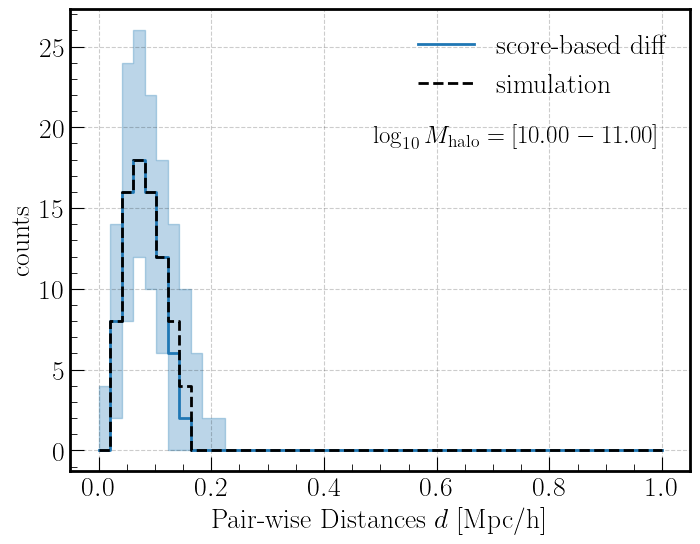

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bins = np.linspace(0, 1, 50)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]


counts = []
for i in range(len(gen_pair_dist)):
    counts.append(np.histogram(gen_pair_dist[i], bins=bins)[0])
counts = np.stack(counts)
counts_q = np.nanpercentile(counts, q=q, axis=0)
ax.plot(
    bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
    label='score-based diff')
ax.fill_between(
    bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
    color='C0', alpha=0.3)

counts = []
for i in range(len(truth_pair_dist)):
    counts.append(np.histogram(gen_pair_dist[i], bins=bins)[0])
counts = np.stack(counts)
counts_q = np.nanpercentile(counts, q=q, axis=0)
ax.plot(
    bins_plot, counts_q[0].repeat(2), color='k', lw=2, ls='--',
    label='simulation')

# annotate the mass bins at the center top of the plot
text = r"$\log_{10} M_{\rm halo} = [%.2f - %.2f$]" % (mass_bin_lo, mass_bin_hi)
ax.text(
    0.95, 0.7, text, fontsize=18,
    transform=ax.transAxes, ha='right', va='bottom')

ax.set_xlabel(r'Pair-wise Distances $d$ [Mpc/h]')
ax.set_ylabel(r'counts')
ax.legend(loc='upper right', fontsize=20)
plt.show()